In [18]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import seaborn as sns
#Baseline
from sklearn.linear_model import LogisticRegression

#Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2, f_classif

# For matrics
from scipy.sparse import csr_matrix

# Factorization
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from catboost import CatBoostClassifier, Pool

#Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2, f_classif

# Downloading data

In [2]:
train = pd.read_csv('data_train.csv').drop('Unnamed: 0', axis=1)
test = pd.read_csv('data_test.csv').drop('Unnamed: 0', axis=1)

In [3]:
feat = pd.read_csv('features.csv', sep='\t', header=0).drop('Unnamed: 0', axis=1)

In [9]:
RANDOM_STATE = 21

In [4]:
train.head(5)

id  vas_id    buy_time  target
0   540968     8.0  1537131600     0.0
1  1454121     4.0  1531688400     0.0
2  2458816     1.0  1534107600     0.0
3  3535012     5.0  1535922000     0.0
4  1693214     1.0  1535922000     0.0

In [5]:
feat.head(5)

id    buy_time          0           1           2           3  \
0  2013026  1531688400  18.910029   46.980888    4.969214   -1.386798   
1  2014722  1539550800  36.690029  152.400888  448.069214  563.833202   
2  2015199  1545598800 -67.019971  157.050888  -63.180786  178.103202   
3  2021765  1534107600   7.010029  150.200888   -6.930786  216.213202   
4  2027465  1533502800 -90.439971  134.220888 -104.380786  153.643202   

            4          5         6          7  ...          243          244  \
0    3.791754  -14.01179 -16.08618 -65.076097  ...  -977.373846  -613.770792   
1  463.841754  568.99821 -16.08618 -53.216097  ...  -891.373846  -544.770792   
2  -68.598246  156.99821   3.51382  25.183903  ...  -977.373846  -613.770792   
3   76.621754  351.84821 -16.08618 -65.076097  ...  -973.373846  -613.770792   
4 -109.798246  132.53821 -16.08618 -65.076097  ...  1643.626154  2007.229208   

          245        246           247        248       249        250  \
0  -25.996269 -37.630448   -301.747724 -25.832889 -0.694428 -12.175933   
1  -20.996269  48.369552     80.252276 -13.832889 -0.694428  -1.175933   
2  -12.996269 -37.630448  10829.252276 -25.832889 -0.694428 -12.175933   
3  -23.996269 -37.630448   -205.747724 -24.832889 -0.694428 -11.175933   
4  206.003731 -21.630448   6667.252276  92.167111 -0.694428  49.824067   

        251  252  
0  -0.45614  0.0  
1  -0.45614  0.0  
2  -0.45614  0.0  
3  -0.45614  1.0  
4  47.54386  0.0  

[5 rows x 255 columns]

In [6]:
train = train.merge(feat, on='id', how='left')

In [7]:
train = train.drop(['buy_time_x', 'buy_time_y'], axis=1)

In [10]:
train_idx, test_idx = train_test_split(train.index, test_size=0.25, random_state=RANDOM_STATE)

y_train, y_test = train['target'].loc[train_idx], train['target'].loc[test_idx]
X_train, X_test = train.drop('target', axis=1).loc[train_idx], train.drop('target', axis=1).loc[test_idx]

print("Train")
print(train['target'].loc[train_idx].value_counts()/train_idx.shape[0])
print()
print("Test")
print(train['target'].loc[test_idx].value_counts()/test_idx.shape[0])

Train
0.0    0.92757
1.0    0.07243
Name: target, dtype: float64

Test
0.0    0.927972
1.0    0.072028
Name: target, dtype: float64


In [11]:
model = CatBoostClassifier(iterations=1000,
                           depth=10, 
                           l2_leaf_reg=5,
                           loss_function='Logloss', #Logloss
                           learning_rate=0.1,
                          )

In [12]:
model.fit(X_train, y_train)

0:	learn: 0.5502184	total: 686ms	remaining: 11m 25s
1:	learn: 0.4480634	total: 1.24s	remaining: 10m 17s
2:	learn: 0.3745543	total: 1.77s	remaining: 9m 48s
3:	learn: 0.3339303	total: 2.35s	remaining: 9m 45s
4:	learn: 0.2985659	total: 2.88s	remaining: 9m 32s
5:	learn: 0.2752413	total: 3.48s	remaining: 9m 35s
6:	learn: 0.2585143	total: 4.09s	remaining: 9m 40s
7:	learn: 0.2394701	total: 4.59s	remaining: 9m 29s
8:	learn: 0.2257225	total: 5.1s	remaining: 9m 21s
9:	learn: 0.2159387	total: 5.58s	remaining: 9m 12s
10:	learn: 0.2108638	total: 6.13s	remaining: 9m 11s
11:	learn: 0.2043365	total: 6.7s	remaining: 9m 11s
12:	learn: 0.2004284	total: 7.16s	remaining: 9m 3s
13:	learn: 0.1975109	total: 7.66s	remaining: 8m 59s
14:	learn: 0.1962907	total: 8.27s	remaining: 9m 2s
15:	learn: 0.1933230	total: 8.8s	remaining: 9m 1s
16:	learn: 0.1922770	total: 9.35s	remaining: 9m
17:	learn: 0.1902341	total: 9.85s	remaining: 8m 57s
18:	learn: 0.1886693	total: 10.4s	remaining: 8m 55s
19:	learn: 0.1875769	total: 11

158:	learn: 0.1761185	total: 1m 26s	remaining: 7m 37s
159:	learn: 0.1760893	total: 1m 27s	remaining: 7m 37s
160:	learn: 0.1760722	total: 1m 27s	remaining: 7m 36s
161:	learn: 0.1760604	total: 1m 28s	remaining: 7m 36s
162:	learn: 0.1760216	total: 1m 28s	remaining: 7m 36s
163:	learn: 0.1760155	total: 1m 29s	remaining: 7m 35s
164:	learn: 0.1759725	total: 1m 29s	remaining: 7m 35s
165:	learn: 0.1759437	total: 1m 30s	remaining: 7m 34s
166:	learn: 0.1758948	total: 1m 31s	remaining: 7m 34s
167:	learn: 0.1758594	total: 1m 31s	remaining: 7m 33s
168:	learn: 0.1758467	total: 1m 32s	remaining: 7m 33s
169:	learn: 0.1758207	total: 1m 32s	remaining: 7m 32s
170:	learn: 0.1757450	total: 1m 33s	remaining: 7m 32s
171:	learn: 0.1756526	total: 1m 33s	remaining: 7m 31s
172:	learn: 0.1756215	total: 1m 34s	remaining: 7m 30s
173:	learn: 0.1755788	total: 1m 34s	remaining: 7m 30s
174:	learn: 0.1755383	total: 1m 35s	remaining: 7m 29s
175:	learn: 0.1755137	total: 1m 36s	remaining: 7m 29s
176:	learn: 0.1755116	total:

311:	learn: 0.1694066	total: 2m 51s	remaining: 6m 17s
312:	learn: 0.1693698	total: 2m 51s	remaining: 6m 17s
313:	learn: 0.1692878	total: 2m 52s	remaining: 6m 16s
314:	learn: 0.1692795	total: 2m 53s	remaining: 6m 16s
315:	learn: 0.1692533	total: 2m 53s	remaining: 6m 15s
316:	learn: 0.1692053	total: 2m 54s	remaining: 6m 15s
317:	learn: 0.1691401	total: 2m 54s	remaining: 6m 14s
318:	learn: 0.1691379	total: 2m 55s	remaining: 6m 14s
319:	learn: 0.1690765	total: 2m 55s	remaining: 6m 13s
320:	learn: 0.1690233	total: 2m 56s	remaining: 6m 13s
321:	learn: 0.1690063	total: 2m 57s	remaining: 6m 12s
322:	learn: 0.1689650	total: 2m 57s	remaining: 6m 12s
323:	learn: 0.1689638	total: 2m 58s	remaining: 6m 11s
324:	learn: 0.1689253	total: 2m 58s	remaining: 6m 10s
325:	learn: 0.1689002	total: 2m 59s	remaining: 6m 10s
326:	learn: 0.1688384	total: 2m 59s	remaining: 6m 9s
327:	learn: 0.1688347	total: 3m	remaining: 6m 9s
328:	learn: 0.1688019	total: 3m	remaining: 6m 8s
329:	learn: 0.1687598	total: 3m 1s	rema

465:	learn: 0.1629386	total: 4m 16s	remaining: 4m 54s
466:	learn: 0.1628703	total: 4m 17s	remaining: 4m 53s
467:	learn: 0.1628668	total: 4m 17s	remaining: 4m 53s
468:	learn: 0.1628476	total: 4m 18s	remaining: 4m 52s
469:	learn: 0.1627935	total: 4m 19s	remaining: 4m 52s
470:	learn: 0.1627604	total: 4m 19s	remaining: 4m 51s
471:	learn: 0.1627238	total: 4m 20s	remaining: 4m 51s
472:	learn: 0.1626458	total: 4m 20s	remaining: 4m 50s
473:	learn: 0.1626228	total: 4m 21s	remaining: 4m 49s
474:	learn: 0.1625473	total: 4m 21s	remaining: 4m 49s
475:	learn: 0.1625171	total: 4m 22s	remaining: 4m 48s
476:	learn: 0.1625154	total: 4m 22s	remaining: 4m 48s
477:	learn: 0.1624866	total: 4m 23s	remaining: 4m 47s
478:	learn: 0.1624300	total: 4m 23s	remaining: 4m 47s
479:	learn: 0.1623929	total: 4m 24s	remaining: 4m 46s
480:	learn: 0.1623315	total: 4m 25s	remaining: 4m 45s
481:	learn: 0.1622992	total: 4m 25s	remaining: 4m 45s
482:	learn: 0.1622317	total: 4m 26s	remaining: 4m 44s
483:	learn: 0.1622105	total:

618:	learn: 0.1566298	total: 5m 41s	remaining: 3m 29s
619:	learn: 0.1566103	total: 5m 41s	remaining: 3m 29s
620:	learn: 0.1565304	total: 5m 42s	remaining: 3m 28s
621:	learn: 0.1564685	total: 5m 42s	remaining: 3m 28s
622:	learn: 0.1564078	total: 5m 43s	remaining: 3m 27s
623:	learn: 0.1563616	total: 5m 43s	remaining: 3m 27s
624:	learn: 0.1563454	total: 5m 44s	remaining: 3m 26s
625:	learn: 0.1563412	total: 5m 44s	remaining: 3m 26s
626:	learn: 0.1562951	total: 5m 45s	remaining: 3m 25s
627:	learn: 0.1562466	total: 5m 45s	remaining: 3m 24s
628:	learn: 0.1562325	total: 5m 46s	remaining: 3m 24s
629:	learn: 0.1561692	total: 5m 47s	remaining: 3m 23s
630:	learn: 0.1561437	total: 5m 47s	remaining: 3m 23s
631:	learn: 0.1561055	total: 5m 48s	remaining: 3m 22s
632:	learn: 0.1560934	total: 5m 48s	remaining: 3m 22s
633:	learn: 0.1560689	total: 5m 49s	remaining: 3m 21s
634:	learn: 0.1560149	total: 5m 49s	remaining: 3m 21s
635:	learn: 0.1559734	total: 5m 50s	remaining: 3m 20s
636:	learn: 0.1558929	total:

772:	learn: 0.1500480	total: 7m 4s	remaining: 2m 4s
773:	learn: 0.1500243	total: 7m 5s	remaining: 2m 4s
774:	learn: 0.1499716	total: 7m 6s	remaining: 2m 3s
775:	learn: 0.1499259	total: 7m 6s	remaining: 2m 3s
776:	learn: 0.1498650	total: 7m 7s	remaining: 2m 2s
777:	learn: 0.1498110	total: 7m 7s	remaining: 2m 2s
778:	learn: 0.1497259	total: 7m 8s	remaining: 2m 1s
779:	learn: 0.1497095	total: 7m 8s	remaining: 2m
780:	learn: 0.1496776	total: 7m 9s	remaining: 2m
781:	learn: 0.1496757	total: 7m 9s	remaining: 1m 59s
782:	learn: 0.1496451	total: 7m 10s	remaining: 1m 59s
783:	learn: 0.1496368	total: 7m 11s	remaining: 1m 58s
784:	learn: 0.1496263	total: 7m 11s	remaining: 1m 58s
785:	learn: 0.1496136	total: 7m 12s	remaining: 1m 57s
786:	learn: 0.1495877	total: 7m 12s	remaining: 1m 57s
787:	learn: 0.1495617	total: 7m 13s	remaining: 1m 56s
788:	learn: 0.1495407	total: 7m 13s	remaining: 1m 56s
789:	learn: 0.1494951	total: 7m 14s	remaining: 1m 55s
790:	learn: 0.1494817	total: 7m 14s	remaining: 1m 54s

926:	learn: 0.1438426	total: 8m 31s	remaining: 40.3s
927:	learn: 0.1438010	total: 8m 32s	remaining: 39.8s
928:	learn: 0.1437742	total: 8m 33s	remaining: 39.2s
929:	learn: 0.1437597	total: 8m 33s	remaining: 38.7s
930:	learn: 0.1437285	total: 8m 34s	remaining: 38.1s
931:	learn: 0.1437040	total: 8m 34s	remaining: 37.6s
932:	learn: 0.1436882	total: 8m 35s	remaining: 37s
933:	learn: 0.1436799	total: 8m 36s	remaining: 36.5s
934:	learn: 0.1436436	total: 8m 36s	remaining: 35.9s
935:	learn: 0.1436360	total: 8m 37s	remaining: 35.4s
936:	learn: 0.1436090	total: 8m 38s	remaining: 34.8s
937:	learn: 0.1436075	total: 8m 38s	remaining: 34.3s
938:	learn: 0.1436061	total: 8m 39s	remaining: 33.7s
939:	learn: 0.1435856	total: 8m 39s	remaining: 33.2s
940:	learn: 0.1435636	total: 8m 40s	remaining: 32.6s
941:	learn: 0.1435005	total: 8m 40s	remaining: 32.1s
942:	learn: 0.1434738	total: 8m 41s	remaining: 31.5s
943:	learn: 0.1434468	total: 8m 41s	remaining: 31s
944:	learn: 0.1434177	total: 8m 42s	remaining: 30.

In [13]:
y_pred = model.predict(X_test)

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96    199526
         1.0       0.41      0.08      0.13     15487

    accuracy                           0.93    215013
   macro avg       0.67      0.53      0.55    215013
weighted avg       0.90      0.93      0.90    215013



In [15]:
f1_score(y_test, y_pred, average='macro')

0.5458717710480725

In [20]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

Top_1: AUC_PR = 0.328
Top_1: AUC_ROC = 0.850


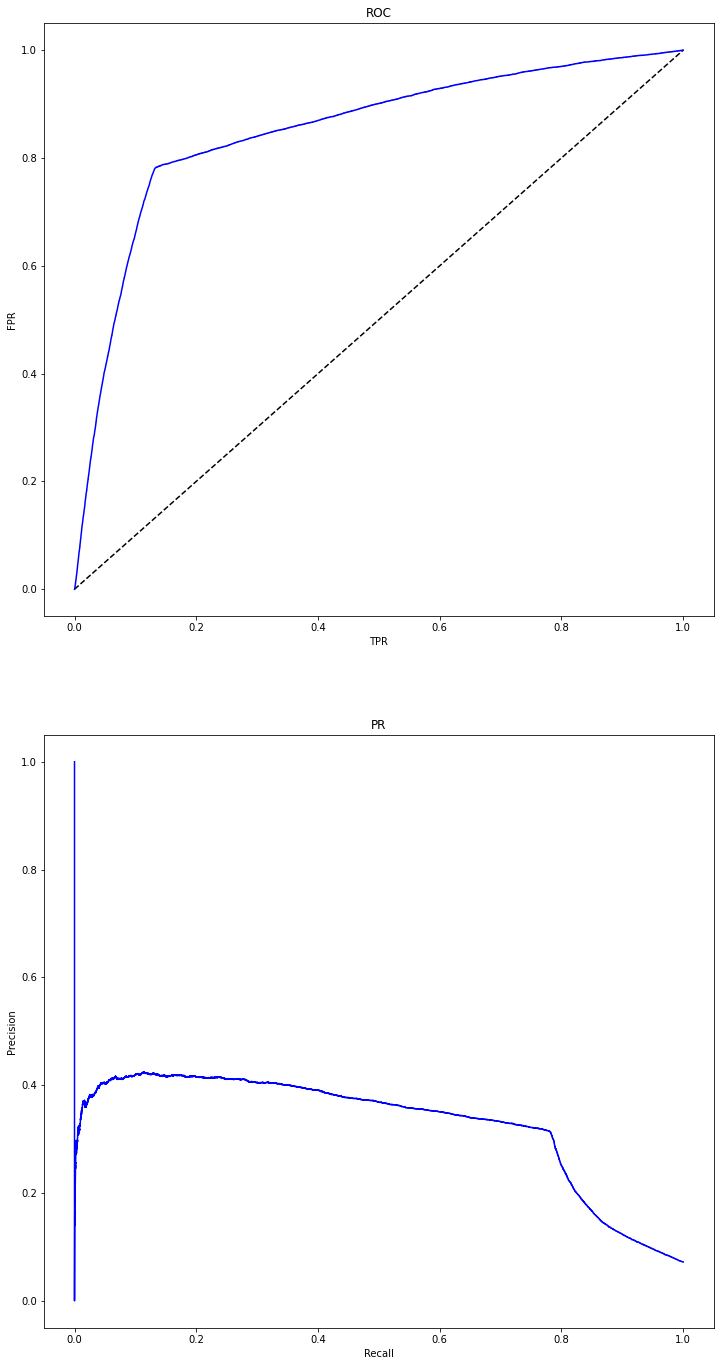

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
ax1.plot(fpr, tpr, label='Top_1', color='b')
ax2.plot(recall, precision, label='Top_1', color='b')
print("Top_1: AUC_PR = %.3f" % auc(recall, precision))
print("Top_1: AUC_ROC = %.3f" % auc(fpr, tpr))

In [23]:
771467 / 60186

12.818047386435383

In [24]:
class_weight = {0: 12.,
                1: 1.,
                }

In [25]:
users = train.id.tolist()
train = train.drop('id', axis=1)

In [26]:
train_idx, test_idx = train_test_split(train.index, test_size=0.25, random_state=RANDOM_STATE)

y_train, y_test = train['target'].loc[train_idx], train['target'].loc[test_idx]
X_train, X_test = train.drop('target', axis=1).loc[train_idx], train.drop('target', axis=1).loc[test_idx]

print("Train")
print(train['target'].loc[train_idx].value_counts()/train_idx.shape[0])
print()
print("Test")
print(train['target'].loc[test_idx].value_counts()/test_idx.shape[0])

Train
0.0    0.92757
1.0    0.07243
Name: target, dtype: float64

Test
0.0    0.927972
1.0    0.072028
Name: target, dtype: float64


In [27]:
model = CatBoostClassifier(iterations=1000,
                           depth=10, 
                           l2_leaf_reg=5,
                           loss_function='Logloss', #Logloss
                           learning_rate=0.1,
                           class_weights=class_weight
                          )

In [28]:
model.fit(X_train, y_train)

0:	learn: 0.4763505	total: 578ms	remaining: 9m 37s
1:	learn: 0.3315842	total: 1.2s	remaining: 9m 57s
2:	learn: 0.2365885	total: 1.85s	remaining: 10m 14s
3:	learn: 0.1743659	total: 2.47s	remaining: 10m 15s
4:	learn: 0.1332702	total: 3.09s	remaining: 10m 14s
5:	learn: 0.1057003	total: 3.67s	remaining: 10m 8s
6:	learn: 0.0869255	total: 4.19s	remaining: 9m 54s
7:	learn: 0.0721528	total: 4.77s	remaining: 9m 51s
8:	learn: 0.0633775	total: 5.31s	remaining: 9m 44s
9:	learn: 0.0546525	total: 5.83s	remaining: 9m 37s
10:	learn: 0.0477179	total: 6.34s	remaining: 9m 29s
11:	learn: 0.0451190	total: 6.93s	remaining: 9m 30s
12:	learn: 0.0424011	total: 7.45s	remaining: 9m 25s
13:	learn: 0.0401659	total: 8s	remaining: 9m 23s
14:	learn: 0.0387239	total: 8.52s	remaining: 9m 19s
15:	learn: 0.0368614	total: 9.06s	remaining: 9m 17s
16:	learn: 0.0355311	total: 9.52s	remaining: 9m 10s
17:	learn: 0.0345658	total: 9.92s	remaining: 9m 1s
18:	learn: 0.0338560	total: 10.4s	remaining: 8m 58s
19:	learn: 0.0333291	tot

158:	learn: 0.0311946	total: 1m 26s	remaining: 7m 36s
159:	learn: 0.0311943	total: 1m 26s	remaining: 7m 36s
160:	learn: 0.0311926	total: 1m 27s	remaining: 7m 36s
161:	learn: 0.0311911	total: 1m 28s	remaining: 7m 35s
162:	learn: 0.0311902	total: 1m 28s	remaining: 7m 35s
163:	learn: 0.0311890	total: 1m 29s	remaining: 7m 34s
164:	learn: 0.0311879	total: 1m 29s	remaining: 7m 34s
165:	learn: 0.0311850	total: 1m 30s	remaining: 7m 33s
166:	learn: 0.0311847	total: 1m 30s	remaining: 7m 33s
167:	learn: 0.0311841	total: 1m 31s	remaining: 7m 33s
168:	learn: 0.0311832	total: 1m 32s	remaining: 7m 32s
169:	learn: 0.0311825	total: 1m 32s	remaining: 7m 31s
170:	learn: 0.0311822	total: 1m 33s	remaining: 7m 31s
171:	learn: 0.0311819	total: 1m 33s	remaining: 7m 31s
172:	learn: 0.0311793	total: 1m 34s	remaining: 7m 30s
173:	learn: 0.0311785	total: 1m 34s	remaining: 7m 30s
174:	learn: 0.0311781	total: 1m 35s	remaining: 7m 29s
175:	learn: 0.0311779	total: 1m 36s	remaining: 7m 29s
176:	learn: 0.0311738	total:

311:	learn: 0.0311459	total: 2m 46s	remaining: 6m 7s
312:	learn: 0.0311456	total: 2m 47s	remaining: 6m 7s
313:	learn: 0.0311456	total: 2m 47s	remaining: 6m 6s
314:	learn: 0.0311456	total: 2m 48s	remaining: 6m 5s
315:	learn: 0.0311441	total: 2m 48s	remaining: 6m 5s
316:	learn: 0.0311440	total: 2m 49s	remaining: 6m 4s
317:	learn: 0.0311440	total: 2m 49s	remaining: 6m 4s
318:	learn: 0.0311438	total: 2m 50s	remaining: 6m 3s
319:	learn: 0.0311438	total: 2m 50s	remaining: 6m 3s
320:	learn: 0.0311437	total: 2m 51s	remaining: 6m 2s
321:	learn: 0.0311437	total: 2m 52s	remaining: 6m 2s
322:	learn: 0.0311420	total: 2m 52s	remaining: 6m 2s
323:	learn: 0.0311419	total: 2m 53s	remaining: 6m 1s
324:	learn: 0.0311419	total: 2m 53s	remaining: 6m 1s
325:	learn: 0.0311414	total: 2m 54s	remaining: 6m
326:	learn: 0.0311414	total: 2m 54s	remaining: 5m 59s
327:	learn: 0.0311414	total: 2m 55s	remaining: 5m 58s
328:	learn: 0.0311398	total: 2m 55s	remaining: 5m 58s
329:	learn: 0.0311397	total: 2m 56s	remaining:

465:	learn: 0.0310995	total: 4m 11s	remaining: 4m 47s
466:	learn: 0.0310995	total: 4m 11s	remaining: 4m 47s
467:	learn: 0.0310991	total: 4m 12s	remaining: 4m 46s
468:	learn: 0.0310990	total: 4m 13s	remaining: 4m 46s
469:	learn: 0.0310986	total: 4m 13s	remaining: 4m 46s
470:	learn: 0.0310986	total: 4m 14s	remaining: 4m 45s
471:	learn: 0.0310983	total: 4m 14s	remaining: 4m 44s
472:	learn: 0.0310983	total: 4m 15s	remaining: 4m 44s
473:	learn: 0.0310982	total: 4m 15s	remaining: 4m 43s
474:	learn: 0.0310981	total: 4m 16s	remaining: 4m 43s
475:	learn: 0.0310979	total: 4m 16s	remaining: 4m 42s
476:	learn: 0.0310969	total: 4m 17s	remaining: 4m 42s
477:	learn: 0.0310968	total: 4m 18s	remaining: 4m 41s
478:	learn: 0.0310968	total: 4m 18s	remaining: 4m 41s
479:	learn: 0.0310967	total: 4m 19s	remaining: 4m 40s
480:	learn: 0.0310966	total: 4m 19s	remaining: 4m 40s
481:	learn: 0.0310965	total: 4m 20s	remaining: 4m 39s
482:	learn: 0.0310965	total: 4m 20s	remaining: 4m 39s
483:	learn: 0.0310962	total:

618:	learn: 0.0310535	total: 5m 37s	remaining: 3m 27s
619:	learn: 0.0310534	total: 5m 38s	remaining: 3m 27s
620:	learn: 0.0310533	total: 5m 38s	remaining: 3m 26s
621:	learn: 0.0310532	total: 5m 39s	remaining: 3m 26s
622:	learn: 0.0310530	total: 5m 39s	remaining: 3m 25s
623:	learn: 0.0310529	total: 5m 40s	remaining: 3m 25s
624:	learn: 0.0310514	total: 5m 41s	remaining: 3m 24s
625:	learn: 0.0310487	total: 5m 41s	remaining: 3m 24s
626:	learn: 0.0310483	total: 5m 42s	remaining: 3m 23s
627:	learn: 0.0310482	total: 5m 42s	remaining: 3m 22s
628:	learn: 0.0310478	total: 5m 43s	remaining: 3m 22s
629:	learn: 0.0310474	total: 5m 43s	remaining: 3m 21s
630:	learn: 0.0310470	total: 5m 44s	remaining: 3m 21s
631:	learn: 0.0310467	total: 5m 44s	remaining: 3m 20s
632:	learn: 0.0310467	total: 5m 44s	remaining: 3m 20s
633:	learn: 0.0310466	total: 5m 45s	remaining: 3m 19s
634:	learn: 0.0310466	total: 5m 46s	remaining: 3m 18s
635:	learn: 0.0310465	total: 5m 46s	remaining: 3m 18s
636:	learn: 0.0310464	total:

771:	learn: 0.0310102	total: 7m 1s	remaining: 2m 4s
772:	learn: 0.0310099	total: 7m 2s	remaining: 2m 3s
773:	learn: 0.0310098	total: 7m 2s	remaining: 2m 3s
774:	learn: 0.0310096	total: 7m 3s	remaining: 2m 2s
775:	learn: 0.0310091	total: 7m 3s	remaining: 2m 2s
776:	learn: 0.0310091	total: 7m 4s	remaining: 2m 1s
777:	learn: 0.0310090	total: 7m 4s	remaining: 2m 1s
778:	learn: 0.0310090	total: 7m 5s	remaining: 2m
779:	learn: 0.0310090	total: 7m 5s	remaining: 2m
780:	learn: 0.0310085	total: 7m 6s	remaining: 1m 59s
781:	learn: 0.0310084	total: 7m 7s	remaining: 1m 59s
782:	learn: 0.0310084	total: 7m 7s	remaining: 1m 58s
783:	learn: 0.0310083	total: 7m 8s	remaining: 1m 57s
784:	learn: 0.0310081	total: 7m 8s	remaining: 1m 57s
785:	learn: 0.0310081	total: 7m 9s	remaining: 1m 56s
786:	learn: 0.0310078	total: 7m 9s	remaining: 1m 56s
787:	learn: 0.0310077	total: 7m 10s	remaining: 1m 55s
788:	learn: 0.0310074	total: 7m 11s	remaining: 1m 55s
789:	learn: 0.0310072	total: 7m 11s	remaining: 1m 54s
790:	

925:	learn: 0.0309679	total: 8m 26s	remaining: 40.5s
926:	learn: 0.0309676	total: 8m 27s	remaining: 39.9s
927:	learn: 0.0309675	total: 8m 27s	remaining: 39.4s
928:	learn: 0.0309673	total: 8m 28s	remaining: 38.9s
929:	learn: 0.0309672	total: 8m 28s	remaining: 38.3s
930:	learn: 0.0309670	total: 8m 29s	remaining: 37.8s
931:	learn: 0.0309668	total: 8m 30s	remaining: 37.2s
932:	learn: 0.0309668	total: 8m 30s	remaining: 36.7s
933:	learn: 0.0309668	total: 8m 31s	remaining: 36.1s
934:	learn: 0.0309664	total: 8m 31s	remaining: 35.6s
935:	learn: 0.0309664	total: 8m 32s	remaining: 35s
936:	learn: 0.0309643	total: 8m 32s	remaining: 34.5s
937:	learn: 0.0309643	total: 8m 33s	remaining: 33.9s
938:	learn: 0.0309643	total: 8m 33s	remaining: 33.4s
939:	learn: 0.0309641	total: 8m 34s	remaining: 32.8s
940:	learn: 0.0309641	total: 8m 34s	remaining: 32.3s
941:	learn: 0.0309641	total: 8m 35s	remaining: 31.7s
942:	learn: 0.0309641	total: 8m 36s	remaining: 31.2s
943:	learn: 0.0309640	total: 8m 36s	remaining: 3

In [29]:
y_pred = model.predict(X_test)

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    199526
         1.0       1.00      0.00      0.00     15487

    accuracy                           0.93    215013
   macro avg       0.96      0.50      0.48    215013
weighted avg       0.93      0.93      0.89    215013



In [31]:
f1_score(y_test, y_pred, average='macro')

0.48138594075445695

In [32]:
y_pred_proba_1 = model.predict_proba(X_test)[:, 1]

Top_1: AUC_PR = 0.328
Top_1: AUC_ROC = 0.850
Top_2: AUC_PR = 0.341
Top_2: AUC_ROC = 0.842


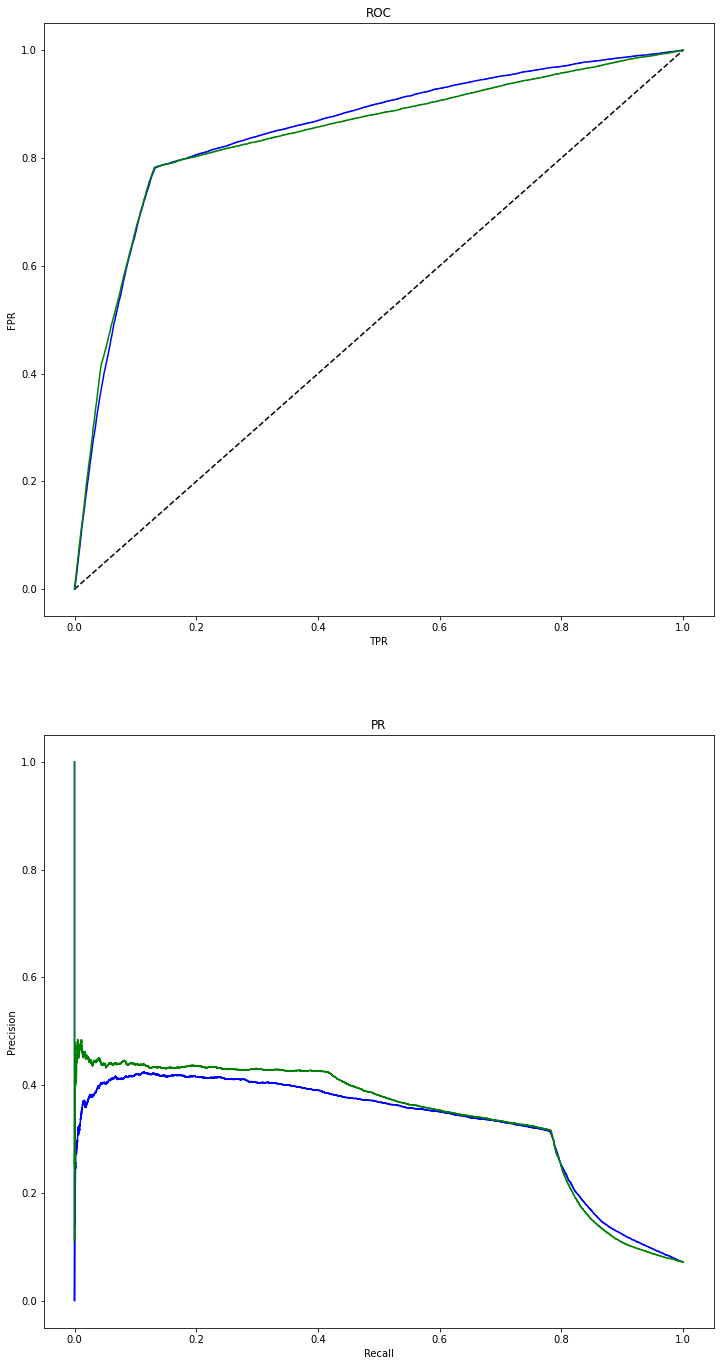

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
ax1.plot(fpr, tpr, label='Top_1', color='b')
ax2.plot(recall, precision, label='Top_1', color='b')
print("Top_1: AUC_PR = %.3f" % auc(recall, precision))
print("Top_1: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_1)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba_1)
ax1.plot(fpr, tpr, label="Top_2", color='g')
ax2.plot(recall, precision, label="Top_2", color='g')
print("Top_2: AUC_PR = %.3f" % auc(recall, precision))
print("Top_2: AUC_ROC = %.3f" % auc(fpr, tpr))





In [34]:
from sklearn.utils.class_weight import compute_class_weight

In [35]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [36]:
class_weights

{0.0: 0.5390427180149719, 1.0: 6.90324272260274}

In [37]:
model = CatBoostClassifier(iterations=1000,
                           depth=10, 
                           l2_leaf_reg=5,
                           loss_function='Logloss', #Logloss
                           learning_rate=0.05,
                           verbose=True,
                           early_stopping_rounds=200,
                           bagging_temperature=1,
                           metric_period=100,
                           class_weights=class_weight
                          )

In [38]:
model.fit(X_train, y_train)

0:	learn: 0.5769917	total: 616ms	remaining: 10m 15s
100:	learn: 0.0315035	total: 53.9s	remaining: 7m 59s
200:	learn: 0.0313453	total: 1m 47s	remaining: 7m 7s
300:	learn: 0.0312139	total: 2m 43s	remaining: 6m 19s
400:	learn: 0.0311699	total: 3m 38s	remaining: 5m 26s
500:	learn: 0.0311657	total: 4m 27s	remaining: 4m 26s
600:	learn: 0.0311538	total: 5m 17s	remaining: 3m 30s
700:	learn: 0.0311438	total: 6m 7s	remaining: 2m 36s
800:	learn: 0.0311322	total: 6m 58s	remaining: 1m 43s
900:	learn: 0.0311105	total: 7m 52s	remaining: 51.9s
999:	learn: 0.0310995	total: 8m 46s	remaining: 0us


In [39]:
y_pred = model.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    199526
         1.0       0.00      0.00      0.00     15487

    accuracy                           0.93    215013
   macro avg       0.46      0.50      0.48    215013
weighted avg       0.86      0.93      0.89    215013



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [42]:
class_weight = {0: 12.,
                1: 1.,
                }

In [43]:
model = CatBoostClassifier(iterations=1000,
                           depth=10, 
#                            l2_leaf_reg=5,
                           loss_function='Logloss', #Logloss
                           learning_rate=0.1,
                           class_weights=class_weight
                          )

In [44]:
model.fit(X_train, y_train)

0:	learn: 0.4762270	total: 679ms	remaining: 11m 18s
1:	learn: 0.3314773	total: 1.45s	remaining: 12m 1s
2:	learn: 0.2365054	total: 2.1s	remaining: 11m 39s
3:	learn: 0.1742939	total: 2.68s	remaining: 11m 7s
4:	learn: 0.1331958	total: 3.25s	remaining: 10m 46s
5:	learn: 0.1056395	total: 3.85s	remaining: 10m 37s
6:	learn: 0.0868737	total: 4.37s	remaining: 10m 20s
7:	learn: 0.0721108	total: 4.95s	remaining: 10m 14s
8:	learn: 0.0633429	total: 5.51s	remaining: 10m 7s
9:	learn: 0.0546096	total: 6.04s	remaining: 9m 58s
10:	learn: 0.0476827	total: 6.55s	remaining: 9m 49s
11:	learn: 0.0450910	total: 7.15s	remaining: 9m 48s
12:	learn: 0.0423750	total: 7.68s	remaining: 9m 42s
13:	learn: 0.0401443	total: 8.25s	remaining: 9m 41s
14:	learn: 0.0387014	total: 8.78s	remaining: 9m 36s
15:	learn: 0.0368441	total: 9.32s	remaining: 9m 33s
16:	learn: 0.0355167	total: 9.78s	remaining: 9m 25s
17:	learn: 0.0345541	total: 10.2s	remaining: 9m 15s
18:	learn: 0.0338455	total: 10.7s	remaining: 9m 11s
19:	learn: 0.0333

157:	learn: 0.0312081	total: 1m 35s	remaining: 8m 28s
158:	learn: 0.0312069	total: 1m 36s	remaining: 8m 28s
159:	learn: 0.0312064	total: 1m 36s	remaining: 8m 27s
160:	learn: 0.0312055	total: 1m 37s	remaining: 8m 26s
161:	learn: 0.0312043	total: 1m 37s	remaining: 8m 25s
162:	learn: 0.0312036	total: 1m 38s	remaining: 8m 24s
163:	learn: 0.0312024	total: 1m 38s	remaining: 8m 23s
164:	learn: 0.0312016	total: 1m 39s	remaining: 8m 23s
165:	learn: 0.0311988	total: 1m 40s	remaining: 8m 22s
166:	learn: 0.0311977	total: 1m 40s	remaining: 8m 21s
167:	learn: 0.0311968	total: 1m 41s	remaining: 8m 20s
168:	learn: 0.0311963	total: 1m 41s	remaining: 8m 20s
169:	learn: 0.0311952	total: 1m 42s	remaining: 8m 19s
170:	learn: 0.0311948	total: 1m 42s	remaining: 8m 18s
171:	learn: 0.0311943	total: 1m 43s	remaining: 8m 18s
172:	learn: 0.0311934	total: 1m 44s	remaining: 8m 17s
173:	learn: 0.0311927	total: 1m 44s	remaining: 8m 16s
174:	learn: 0.0311923	total: 1m 45s	remaining: 8m 16s
175:	learn: 0.0311913	total:

310:	learn: 0.0311391	total: 3m 3s	remaining: 6m 46s
311:	learn: 0.0311385	total: 3m 4s	remaining: 6m 46s
312:	learn: 0.0311381	total: 3m 4s	remaining: 6m 45s
313:	learn: 0.0311381	total: 3m 5s	remaining: 6m 44s
314:	learn: 0.0311379	total: 3m 5s	remaining: 6m 44s
315:	learn: 0.0311377	total: 3m 6s	remaining: 6m 43s
316:	learn: 0.0311376	total: 3m 7s	remaining: 6m 42s
317:	learn: 0.0311371	total: 3m 7s	remaining: 6m 42s
318:	learn: 0.0311370	total: 3m 8s	remaining: 6m 41s
319:	learn: 0.0311365	total: 3m 8s	remaining: 6m 41s
320:	learn: 0.0311363	total: 3m 9s	remaining: 6m 40s
321:	learn: 0.0311353	total: 3m 9s	remaining: 6m 40s
322:	learn: 0.0311351	total: 3m 10s	remaining: 6m 39s
323:	learn: 0.0311335	total: 3m 11s	remaining: 6m 38s
324:	learn: 0.0311335	total: 3m 11s	remaining: 6m 38s
325:	learn: 0.0311332	total: 3m 12s	remaining: 6m 37s
326:	learn: 0.0311328	total: 3m 12s	remaining: 6m 37s
327:	learn: 0.0311327	total: 3m 13s	remaining: 6m 36s
328:	learn: 0.0311327	total: 3m 14s	rema

463:	learn: 0.0310845	total: 4m 34s	remaining: 5m 17s
464:	learn: 0.0310840	total: 4m 35s	remaining: 5m 16s
465:	learn: 0.0310837	total: 4m 35s	remaining: 5m 15s
466:	learn: 0.0310831	total: 4m 36s	remaining: 5m 15s
467:	learn: 0.0310825	total: 4m 37s	remaining: 5m 15s
468:	learn: 0.0310824	total: 4m 37s	remaining: 5m 14s
469:	learn: 0.0310823	total: 4m 38s	remaining: 5m 13s
470:	learn: 0.0310821	total: 4m 39s	remaining: 5m 13s
471:	learn: 0.0310813	total: 4m 39s	remaining: 5m 12s
472:	learn: 0.0310809	total: 4m 40s	remaining: 5m 12s
473:	learn: 0.0310806	total: 4m 40s	remaining: 5m 11s
474:	learn: 0.0310805	total: 4m 41s	remaining: 5m 11s
475:	learn: 0.0310802	total: 4m 41s	remaining: 5m 10s
476:	learn: 0.0310801	total: 4m 42s	remaining: 5m 9s
477:	learn: 0.0310787	total: 4m 43s	remaining: 5m 9s
478:	learn: 0.0310786	total: 4m 43s	remaining: 5m 8s
479:	learn: 0.0310780	total: 4m 44s	remaining: 5m 7s
480:	learn: 0.0310780	total: 4m 44s	remaining: 5m 7s
481:	learn: 0.0310779	total: 4m 4

617:	learn: 0.0310188	total: 6m 3s	remaining: 3m 44s
618:	learn: 0.0310186	total: 6m 4s	remaining: 3m 44s
619:	learn: 0.0310185	total: 6m 5s	remaining: 3m 43s
620:	learn: 0.0310183	total: 6m 5s	remaining: 3m 43s
621:	learn: 0.0310183	total: 6m 6s	remaining: 3m 42s
622:	learn: 0.0310147	total: 6m 6s	remaining: 3m 41s
623:	learn: 0.0310146	total: 6m 7s	remaining: 3m 41s
624:	learn: 0.0310142	total: 6m 7s	remaining: 3m 40s
625:	learn: 0.0310142	total: 6m 8s	remaining: 3m 40s
626:	learn: 0.0310136	total: 6m 9s	remaining: 3m 39s
627:	learn: 0.0310132	total: 6m 9s	remaining: 3m 39s
628:	learn: 0.0310131	total: 6m 10s	remaining: 3m 38s
629:	learn: 0.0310130	total: 6m 11s	remaining: 3m 38s
630:	learn: 0.0310130	total: 6m 11s	remaining: 3m 37s
631:	learn: 0.0310113	total: 6m 12s	remaining: 3m 36s
632:	learn: 0.0310113	total: 6m 12s	remaining: 3m 36s
633:	learn: 0.0310109	total: 6m 13s	remaining: 3m 35s
634:	learn: 0.0310109	total: 6m 13s	remaining: 3m 34s
635:	learn: 0.0310109	total: 6m 14s	rem

770:	learn: 0.0309711	total: 7m 33s	remaining: 2m 14s
771:	learn: 0.0309711	total: 7m 34s	remaining: 2m 14s
772:	learn: 0.0309710	total: 7m 34s	remaining: 2m 13s
773:	learn: 0.0309710	total: 7m 35s	remaining: 2m 12s
774:	learn: 0.0309674	total: 7m 35s	remaining: 2m 12s
775:	learn: 0.0309670	total: 7m 36s	remaining: 2m 11s
776:	learn: 0.0309651	total: 7m 36s	remaining: 2m 11s
777:	learn: 0.0309648	total: 7m 37s	remaining: 2m 10s
778:	learn: 0.0309646	total: 7m 38s	remaining: 2m 9s
779:	learn: 0.0309644	total: 7m 38s	remaining: 2m 9s
780:	learn: 0.0309626	total: 7m 39s	remaining: 2m 8s
781:	learn: 0.0309625	total: 7m 39s	remaining: 2m 8s
782:	learn: 0.0309620	total: 7m 40s	remaining: 2m 7s
783:	learn: 0.0309620	total: 7m 41s	remaining: 2m 7s
784:	learn: 0.0309619	total: 7m 41s	remaining: 2m 6s
785:	learn: 0.0309616	total: 7m 42s	remaining: 2m 5s
786:	learn: 0.0309616	total: 7m 42s	remaining: 2m 5s
787:	learn: 0.0309607	total: 7m 43s	remaining: 2m 4s
788:	learn: 0.0309606	total: 7m 44s	re

924:	learn: 0.0309278	total: 9m 3s	remaining: 44.1s
925:	learn: 0.0309277	total: 9m 4s	remaining: 43.5s
926:	learn: 0.0309274	total: 9m 4s	remaining: 42.9s
927:	learn: 0.0309271	total: 9m 5s	remaining: 42.3s
928:	learn: 0.0309269	total: 9m 6s	remaining: 41.8s
929:	learn: 0.0309268	total: 9m 7s	remaining: 41.2s
930:	learn: 0.0309262	total: 9m 7s	remaining: 40.6s
931:	learn: 0.0309261	total: 9m 8s	remaining: 40s
932:	learn: 0.0309259	total: 9m 9s	remaining: 39.4s
933:	learn: 0.0309258	total: 9m 9s	remaining: 38.8s
934:	learn: 0.0309258	total: 9m 10s	remaining: 38.3s
935:	learn: 0.0309257	total: 9m 10s	remaining: 37.7s
936:	learn: 0.0309257	total: 9m 11s	remaining: 37.1s
937:	learn: 0.0309256	total: 9m 12s	remaining: 36.5s
938:	learn: 0.0309254	total: 9m 12s	remaining: 35.9s
939:	learn: 0.0309253	total: 9m 13s	remaining: 35.3s
940:	learn: 0.0309252	total: 9m 13s	remaining: 34.7s
941:	learn: 0.0309252	total: 9m 14s	remaining: 34.1s
942:	learn: 0.0309251	total: 9m 15s	remaining: 33.6s
943:	

In [45]:
y_pred = model.predict(X_test)

In [46]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    199526
         1.0       1.00      0.00      0.00     15487

    accuracy                           0.93    215013
   macro avg       0.96      0.50      0.48    215013
weighted avg       0.93      0.93      0.89    215013



In [48]:
n_unique_v_of_feature = X_test.nunique()

In [49]:
f_cat = set(n_unique_v_of_feature[n_unique_v_of_feature < 10].index.tolist())
len(f_cat)

37

In [50]:
f_const = set(n_unique_v_of_feature[n_unique_v_of_feature == 1].index.tolist())
len(f_const)

6

In [59]:
f_cat = [i for i in f_cat if i not in f_const]

In [62]:
'75' in f_cat

False

In [53]:
X_train = X_train.drop(f_const, axis=1)

In [54]:
X_test = X_test.drop(f_const, axis=1)

In [63]:
model = CatBoostClassifier(iterations=1000,
                           depth=10, 
                           l2_leaf_reg=5,
                           loss_function='Logloss', #Logloss
                           learning_rate=0.1,
                           early_stopping_rounds=200,
                           metric_period=100,
                           class_weights=class_weight,
                           cat_features=f_cat
                          )

In [68]:
for cat in f_cat:
    X_train[cat] = X_train[cat].apply(lambda x: int(x))

In [69]:
model.fit(X_train, y_train)

0:	learn: 0.4763604	total: 1.16s	remaining: 19m 23s
100:	learn: 0.0313208	total: 1m 35s	remaining: 14m 12s
200:	learn: 0.0312729	total: 3m 1s	remaining: 11m 59s
300:	learn: 0.0312722	total: 4m 2s	remaining: 9m 22s
400:	learn: 0.0312708	total: 5m 30s	remaining: 8m 13s
500:	learn: 0.0312456	total: 7m 7s	remaining: 7m 6s
600:	learn: 0.0312342	total: 8m 40s	remaining: 5m 45s
700:	learn: 0.0312225	total: 10m 25s	remaining: 4m 26s
800:	learn: 0.0312107	total: 12m 4s	remaining: 2m 59s
900:	learn: 0.0311895	total: 13m 47s	remaining: 1m 30s
999:	learn: 0.0311639	total: 15m 32s	remaining: 0us


In [71]:
for cat in f_cat:
    X_test[cat] = X_test[cat].apply(lambda x: int(x))

In [72]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    199526
         1.0       0.00      0.00      0.00     15487

    accuracy                           0.93    215013
   macro avg       0.46      0.50      0.48    215013
weighted avg       0.86      0.93      0.89    215013



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [74]:
model = CatBoostClassifier(iterations=1000,
                           depth=10, 
                           l2_leaf_reg=5,
                           loss_function='Logloss', #Logloss
                           learning_rate=0.1,
                           early_stopping_rounds=200,
                           metric_period=100,
                           cat_features=f_cat
                          )
model.fit(X_train, y_train)

0:	learn: 0.5509156	total: 1.19s	remaining: 19m 44s
100:	learn: 0.1799944	total: 1m 46s	remaining: 15m 52s
200:	learn: 0.1759112	total: 3m 32s	remaining: 14m 6s
300:	learn: 0.1710657	total: 5m 18s	remaining: 12m 19s
400:	learn: 0.1663931	total: 7m 5s	remaining: 10m 36s
500:	learn: 0.1620238	total: 8m 55s	remaining: 8m 53s
600:	learn: 0.1575498	total: 10m 43s	remaining: 7m 7s
700:	learn: 0.1524531	total: 12m 33s	remaining: 5m 21s
800:	learn: 0.1486019	total: 14m 20s	remaining: 3m 33s
900:	learn: 0.1444520	total: 16m 7s	remaining: 1m 46s
999:	learn: 0.1404329	total: 17m 53s	remaining: 0us


In [75]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96    199526
         1.0       0.40      0.07      0.12     15487

    accuracy                           0.93    215013
   macro avg       0.67      0.53      0.54    215013
weighted avg       0.89      0.93      0.90    215013



In [76]:
model = CatBoostClassifier()
model.fit(X_train, y_train)

Learning rate set to 0.163165
0:	learn: 0.4760919	total: 181ms	remaining: 3m
1:	learn: 0.3541554	total: 315ms	remaining: 2m 37s
2:	learn: 0.2991341	total: 434ms	remaining: 2m 24s
3:	learn: 0.2590388	total: 553ms	remaining: 2m 17s
4:	learn: 0.2385276	total: 682ms	remaining: 2m 15s
5:	learn: 0.2223650	total: 794ms	remaining: 2m 11s
6:	learn: 0.2084488	total: 921ms	remaining: 2m 10s
7:	learn: 0.1999876	total: 1.06s	remaining: 2m 11s
8:	learn: 0.1979269	total: 1.18s	remaining: 2m 9s
9:	learn: 0.1936458	total: 1.34s	remaining: 2m 12s
10:	learn: 0.1906744	total: 1.47s	remaining: 2m 12s
11:	learn: 0.1888811	total: 1.6s	remaining: 2m 12s
12:	learn: 0.1881948	total: 1.71s	remaining: 2m 9s
13:	learn: 0.1872270	total: 1.84s	remaining: 2m 9s
14:	learn: 0.1865333	total: 1.99s	remaining: 2m 10s
15:	learn: 0.1859720	total: 2.12s	remaining: 2m 10s
16:	learn: 0.1857296	total: 2.28s	remaining: 2m 11s
17:	learn: 0.1855273	total: 2.41s	remaining: 2m 11s
18:	learn: 0.1854698	total: 2.52s	remaining: 2m 9s
1

158:	learn: 0.1826112	total: 19.8s	remaining: 1m 44s
159:	learn: 0.1825861	total: 19.9s	remaining: 1m 44s
160:	learn: 0.1825634	total: 20.1s	remaining: 1m 44s
161:	learn: 0.1825409	total: 20.2s	remaining: 1m 44s
162:	learn: 0.1825243	total: 20.3s	remaining: 1m 44s
163:	learn: 0.1825084	total: 20.4s	remaining: 1m 44s
164:	learn: 0.1824962	total: 20.5s	remaining: 1m 43s
165:	learn: 0.1824755	total: 20.7s	remaining: 1m 43s
166:	learn: 0.1824473	total: 20.8s	remaining: 1m 43s
167:	learn: 0.1824199	total: 20.9s	remaining: 1m 43s
168:	learn: 0.1824043	total: 21s	remaining: 1m 43s
169:	learn: 0.1823918	total: 21.1s	remaining: 1m 43s
170:	learn: 0.1823705	total: 21.3s	remaining: 1m 43s
171:	learn: 0.1823582	total: 21.4s	remaining: 1m 42s
172:	learn: 0.1823516	total: 21.5s	remaining: 1m 42s
173:	learn: 0.1823376	total: 21.6s	remaining: 1m 42s
174:	learn: 0.1823215	total: 21.7s	remaining: 1m 42s
175:	learn: 0.1823096	total: 21.8s	remaining: 1m 42s
176:	learn: 0.1822997	total: 21.9s	remaining: 1m

315:	learn: 0.1801587	total: 38.5s	remaining: 1m 23s
316:	learn: 0.1801428	total: 38.6s	remaining: 1m 23s
317:	learn: 0.1801190	total: 38.7s	remaining: 1m 23s
318:	learn: 0.1801041	total: 38.8s	remaining: 1m 22s
319:	learn: 0.1800868	total: 38.9s	remaining: 1m 22s
320:	learn: 0.1800584	total: 39.1s	remaining: 1m 22s
321:	learn: 0.1800443	total: 39.2s	remaining: 1m 22s
322:	learn: 0.1800274	total: 39.3s	remaining: 1m 22s
323:	learn: 0.1800137	total: 39.5s	remaining: 1m 22s
324:	learn: 0.1800008	total: 39.6s	remaining: 1m 22s
325:	learn: 0.1799840	total: 39.7s	remaining: 1m 22s
326:	learn: 0.1799825	total: 39.8s	remaining: 1m 21s
327:	learn: 0.1799686	total: 39.9s	remaining: 1m 21s
328:	learn: 0.1799503	total: 40.1s	remaining: 1m 21s
329:	learn: 0.1799396	total: 40.2s	remaining: 1m 21s
330:	learn: 0.1799272	total: 40.3s	remaining: 1m 21s
331:	learn: 0.1799168	total: 40.4s	remaining: 1m 21s
332:	learn: 0.1799118	total: 40.5s	remaining: 1m 21s
333:	learn: 0.1798867	total: 40.6s	remaining: 

473:	learn: 0.1779100	total: 57.3s	remaining: 1m 3s
474:	learn: 0.1778947	total: 57.4s	remaining: 1m 3s
475:	learn: 0.1778787	total: 57.5s	remaining: 1m 3s
476:	learn: 0.1778673	total: 57.6s	remaining: 1m 3s
477:	learn: 0.1778518	total: 57.7s	remaining: 1m 3s
478:	learn: 0.1778355	total: 57.9s	remaining: 1m 2s
479:	learn: 0.1778242	total: 58s	remaining: 1m 2s
480:	learn: 0.1778114	total: 58.1s	remaining: 1m 2s
481:	learn: 0.1777978	total: 58.2s	remaining: 1m 2s
482:	learn: 0.1777857	total: 58.4s	remaining: 1m 2s
483:	learn: 0.1777761	total: 58.5s	remaining: 1m 2s
484:	learn: 0.1777547	total: 58.6s	remaining: 1m 2s
485:	learn: 0.1777387	total: 58.7s	remaining: 1m 2s
486:	learn: 0.1777336	total: 58.8s	remaining: 1m 1s
487:	learn: 0.1777127	total: 59s	remaining: 1m 1s
488:	learn: 0.1776980	total: 59.1s	remaining: 1m 1s
489:	learn: 0.1776757	total: 59.2s	remaining: 1m 1s
490:	learn: 0.1776561	total: 59.3s	remaining: 1m 1s
491:	learn: 0.1776446	total: 59.5s	remaining: 1m 1s
492:	learn: 0.17

631:	learn: 0.1757151	total: 1m 17s	remaining: 45.2s
632:	learn: 0.1757060	total: 1m 17s	remaining: 45s
633:	learn: 0.1756951	total: 1m 17s	remaining: 44.9s
634:	learn: 0.1756711	total: 1m 17s	remaining: 44.8s
635:	learn: 0.1756544	total: 1m 18s	remaining: 44.7s
636:	learn: 0.1756409	total: 1m 18s	remaining: 44.6s
637:	learn: 0.1756233	total: 1m 18s	remaining: 44.4s
638:	learn: 0.1756190	total: 1m 18s	remaining: 44.3s
639:	learn: 0.1756025	total: 1m 18s	remaining: 44.2s
640:	learn: 0.1755826	total: 1m 18s	remaining: 44.1s
641:	learn: 0.1755714	total: 1m 18s	remaining: 43.9s
642:	learn: 0.1755549	total: 1m 18s	remaining: 43.8s
643:	learn: 0.1755317	total: 1m 19s	remaining: 43.7s
644:	learn: 0.1755254	total: 1m 19s	remaining: 43.6s
645:	learn: 0.1755231	total: 1m 19s	remaining: 43.4s
646:	learn: 0.1755134	total: 1m 19s	remaining: 43.3s
647:	learn: 0.1755017	total: 1m 19s	remaining: 43.2s
648:	learn: 0.1754920	total: 1m 19s	remaining: 43.1s
649:	learn: 0.1754777	total: 1m 19s	remaining: 4

788:	learn: 0.1735475	total: 1m 37s	remaining: 26s
789:	learn: 0.1735442	total: 1m 37s	remaining: 25.8s
790:	learn: 0.1735320	total: 1m 37s	remaining: 25.7s
791:	learn: 0.1735228	total: 1m 37s	remaining: 25.6s
792:	learn: 0.1735150	total: 1m 37s	remaining: 25.5s
793:	learn: 0.1735014	total: 1m 37s	remaining: 25.3s
794:	learn: 0.1734794	total: 1m 37s	remaining: 25.2s
795:	learn: 0.1734665	total: 1m 37s	remaining: 25.1s
796:	learn: 0.1734473	total: 1m 38s	remaining: 25s
797:	learn: 0.1734364	total: 1m 38s	remaining: 24.8s
798:	learn: 0.1734249	total: 1m 38s	remaining: 24.7s
799:	learn: 0.1734088	total: 1m 38s	remaining: 24.6s
800:	learn: 0.1734052	total: 1m 38s	remaining: 24.5s
801:	learn: 0.1733847	total: 1m 38s	remaining: 24.3s
802:	learn: 0.1733741	total: 1m 38s	remaining: 24.2s
803:	learn: 0.1733614	total: 1m 38s	remaining: 24.1s
804:	learn: 0.1733541	total: 1m 39s	remaining: 24s
805:	learn: 0.1733351	total: 1m 39s	remaining: 23.9s
806:	learn: 0.1733201	total: 1m 39s	remaining: 23.7s

944:	learn: 0.1714542	total: 1m 57s	remaining: 6.81s
945:	learn: 0.1714342	total: 1m 57s	remaining: 6.69s
946:	learn: 0.1714254	total: 1m 57s	remaining: 6.56s
947:	learn: 0.1714119	total: 1m 57s	remaining: 6.44s
948:	learn: 0.1714084	total: 1m 57s	remaining: 6.31s
949:	learn: 0.1713919	total: 1m 57s	remaining: 6.19s
950:	learn: 0.1713878	total: 1m 57s	remaining: 6.07s
951:	learn: 0.1713751	total: 1m 57s	remaining: 5.94s
952:	learn: 0.1713582	total: 1m 58s	remaining: 5.82s
953:	learn: 0.1713519	total: 1m 58s	remaining: 5.69s
954:	learn: 0.1713431	total: 1m 58s	remaining: 5.57s
955:	learn: 0.1713292	total: 1m 58s	remaining: 5.45s
956:	learn: 0.1713127	total: 1m 58s	remaining: 5.32s
957:	learn: 0.1712983	total: 1m 58s	remaining: 5.2s
958:	learn: 0.1712928	total: 1m 58s	remaining: 5.08s
959:	learn: 0.1712780	total: 1m 58s	remaining: 4.95s
960:	learn: 0.1712634	total: 1m 59s	remaining: 4.83s
961:	learn: 0.1712439	total: 1m 59s	remaining: 4.71s
962:	learn: 0.1712322	total: 1m 59s	remaining: 

In [77]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    199526
         1.0       0.43      0.04      0.07     15487

    accuracy                           0.93    215013
   macro avg       0.68      0.52      0.52    215013
weighted avg       0.89      0.93      0.90    215013



In [80]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [82]:
model = CatBoostClassifier(iterations=1000,
                           depth=10, 
                           l2_leaf_reg=0.1,
                           loss_function='Logloss', #Logloss
                           learning_rate=0.1,
                           early_stopping_rounds=200,
                           metric_period=100,
                           cat_features=f_cat,
                          )
model.fit(X_train, y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.5508395	total: 1.22s	remaining: 20m 16s
100:	learn: 0.1776031	total: 1m 53s	remaining: 16m 51s
200:	learn: 0.1699104	total: 3m 45s	remaining: 14m 55s
300:	learn: 0.1631177	total: 5m 33s	remaining: 12m 55s
400:	learn: 0.1560586	total: 7m 22s	remaining: 11m
500:	learn: 0.1491134	total: 9m 8s	remaining: 9m 6s
600:	learn: 0.1426110	total: 10m 55s	remaining: 7m 14s
700:	learn: 0.1361263	total: 12m 45s	remaining: 5m 26s
800:	learn: 0.1300069	total: 14m 36s	remaining: 3m 37s
900:	learn: 0.1241546	total: 16m 24s	remaining: 1m 48s
999:	learn: 0.1185657	total: 18m 9s	remaining: 0us


In [83]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96    199526
         1.0       0.37      0.09      0.14     15487

    accuracy                           0.92    215013
   macro avg       0.65      0.54      0.55    215013
weighted avg       0.89      0.92      0.90    215013



In [ ]:
model = CatBoostClassifier(iterations=1000,
                           depth=10, 
                           l2_leaf_reg=5,
                           loss_function='Logloss', #Logloss
                           learning_rate=0.05,
                           early_stopping_rounds=200,
                           metric_period=100,
                           cat_features=f_cat,
                    
                          )
model.fit(X_train, y_train,       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6180874	total: 1.2s	remaining: 19m 54s
100:	learn: 0.1823809	total: 1m 54s	remaining: 17m 2s
200:	learn: 0.1800137	total: 3m 48s	remaining: 15m 10s
300:	learn: 0.1778210	total: 5m 44s	remaining: 13m 19s


In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))